<a href="https://colab.research.google.com/github/s-choung/Simulation_tutorials/blob/main/handson4_dft_adsorption_application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Get GPAW as we did last session
- GPAW(+dependencies+ASE)
- POVRAY

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,319 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:14 http://se

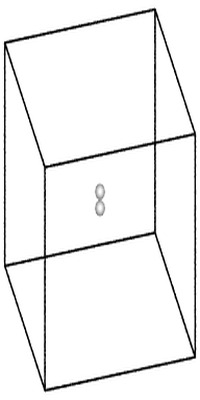

In [1]:
!apt-get update
!apt-get install -y python3-dev libopenblas-dev liblapack-dev libfftw3-dev libxc-dev
!pip install gpaw
!gpaw test
!wget https://wiki.fysik.dtu.dk/gpaw-files/gpaw-setups-24.1.0.tar.gz
!tar -xzf gpaw-setups-24.1.0.tar.gz

import os
import gzip
import shutil

# Define the path to the setup files
setup_path = '/content/gpaw-setups-24.1.0'

# Uncompress all .gz files in the setup directory
for filename in os.listdir(setup_path):
    if filename.endswith('.gz'):
        filepath = os.path.join(setup_path, filename)
        with gzip.open(filepath, 'rb') as f_in:
            with open(filepath[:-3], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

# Set the GPAW_SETUP_PATH environment variable
os.environ['GPAW_SETUP_PATH'] = setup_path
# Verify the environment variable
print("GPAW_SETUP_PATH:", os.environ['GPAW_SETUP_PATH'])

# Import ASE and GPAW and run your calculation
from ase import Atoms
from gpaw import GPAW

# Define the atomic structure
d = 0.74
a = 10.0

h2 = Atoms('H2',
              positions=[(0, 0, 0),
                         (0, 0, d)],
              cell=(a, a, a))
h2.center()
# Initialize GPAW calculator without specifying the 'setups' parameter
calc = GPAW(mode='fd', nbands=2, txt='h2.txt')
h2.calc = calc

# Run the calculation
print("Forces on atoms:", h2.get_forces())
print("Energies on atoms:", h2.get_total_energy())

!sudo apt-get install povray  ## visulization program

import shutil
from ase.io import write  # Import the write function from ASE
from PIL import Image
from IPython.display import display  # Import display for Jupyter Notebooks


def visual(structure, max_size=(200, 200), stretch_y=2.0, rotation='15z,-60x', png_save_path='./'):
    renderer = write('./temp.pov', structure, rotation=rotation)
    renderer.render()
    image_path = './temp.png'
    img = Image.open(image_path)

    # Calculate new size with stretch factor
    new_size = (max_size[0], int(max_size[1] * stretch_y))
    img = img.resize(new_size, Image.LANCZOS)
    display(img)

    # Move files to output directory
    files = ['./temp.ini', './temp.pov', './temp.png']
    destination = './output/'

    # Ensure destination directory exists
    os.makedirs(destination, exist_ok=True)

    for file in files:
        # Remove the file in the destination directory if it exists
        if os.path.isfile(os.path.join(destination, os.path.basename(file))):
            os.remove(os.path.join(destination, os.path.basename(file)))

        if file == './temp.png':
            new_file_name = png_save_path + f'temp.png'
        else:
            new_file_name = os.path.basename(file)
        shutil.move(file, os.path.join(destination, new_file_name))
visual(h2)

## Lets make a catalyst surface using ase.build library

Type all the calculation setups defined in last hands-on session

In [4]:
# Parameters
name = 'Pt-fcc'
a0 = 3.93  # fcc lattice parameter
k = 1# change it to larger value than 1
element='Pt'
N_layer = 4 # number of layers
size = 1 #  supercell size
vac = 7.5

Positions: [[0.00000000e+00 0.00000000e+00 7.50000000e+00]
 [1.38946483e+00 8.02207891e-01 9.76898656e+00]
 [2.25943403e-17 1.60441578e+00 1.20379731e+01]
 [0.00000000e+00 0.00000000e+00 1.43069597e+01]]
Time taken: 17.16 seconds


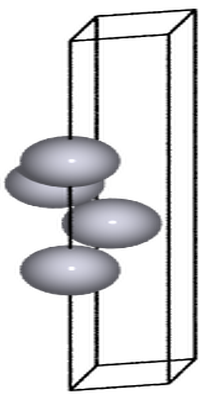

In [5]:
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW
from ase.build import bulk
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ase.build import fcc111
from ase.constraints import FixAtoms

surf = fcc111(element, (size, size, N_layer), a=a0, vacuum=vac)
median_z = np.median(surf.positions[:, 2])
constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
surf.set_constraint(constraint)

# Set up the GPAW calculator
calc = GPAW(mode=PW(300), # change it to larger than 400
            kpts=(k, k, 1),
            xc='PBE',
            txt='slab.txt')
surf.calc = calc

start_time = time.time()
E_slab = surf.get_potential_energy()
end_time = time.time()
elapsed_time = end_time - start_time
print("Positions:", surf.get_positions())
# Print the energy and the elapsed time
print(f'Time taken: {elapsed_time:.2f} seconds')
visual(surf)


In [6]:
def enlarge_and_visual(atoms,angle='15z,-60x'):
  temp=atoms.copy()
  temp=temp*(3,3,1)
  temp.cell=atoms.cell
  visual(temp, rotation=angle)

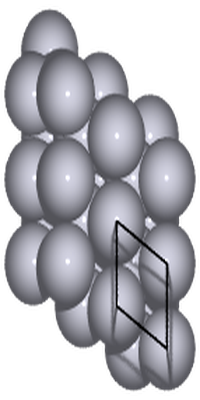

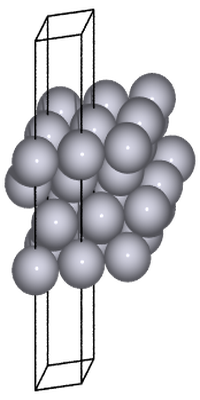

In [7]:
enlarge_and_visual(surf,angle='90z,-0x')
enlarge_and_visual(surf,angle='15z,-60x')

# Adsorption energy of CO on Pt(111) surface

Atoms(symbols='Pt4', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))
Atoms(symbols='Pt4CO', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))


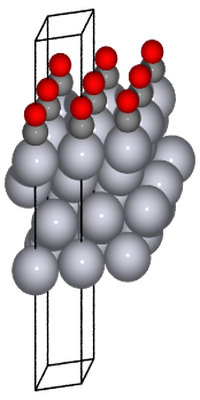

Adsorption energy: 2.34


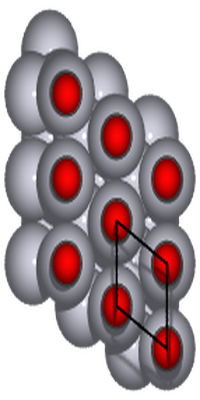

In [8]:
import time
import numpy as np
from ase.build import fcc100
from ase.constraints import FixAtoms
from gpaw import GPAW, PW
from ase.build import add_adsorbate

# Calculating CO gas
CO = Atoms('CO',
              positions=[(0, 0, 0),
                         (0, 0, 1.1)],
              cell=(a, a, a),pbc='TRUE')
CO.calc = calc
E_CO = CO.get_potential_energy()

adslab=surf.copy()
print(adslab)
add_adsorbate(adslab, CO, 1.8, 'ontop')
print(adslab)
enlarge_and_visual(adslab)
adslab.calc = calc
E_adslab = adslab.get_potential_energy()

E_ads= E_adslab - E_CO - E_slab
print('Adsorption energy:', round(E_ads,2))
enlarge_and_visual(adslab,angle='90z,-0x')

# Assignment Adsorption of H

Atoms(symbols='Pt4', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))
Atoms(symbols='Pt4H', pbc=[True, True, False], cell=[[2.778929650063132, 0.0, 0.0], [1.389464825031566, 2.4066236722844723, 0.0], [0.0, 0.0, 21.806959673745688]], tags=..., constraint=FixAtoms(indices=[0, 1]))
Before optimize


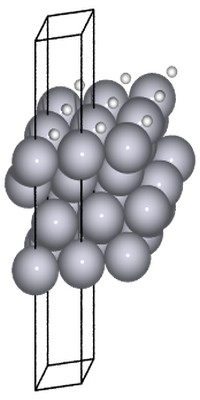

After optimize


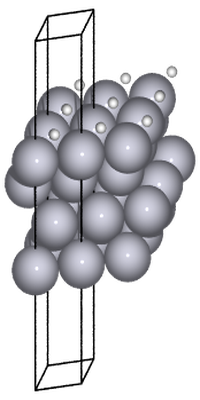

Adsorption energy: -2.520657251953473


In [11]:
gas = Atoms('H2',
              positions=[(0, 0, 0),
                         (0, 0, 1.1)],
              cell=(a, a, a),pbc='TRUE')

gas.calc = calc
E_gas = gas.get_potential_energy()

adsorbate_atom=Atoms('H')
adslab=surf.copy()
print(adslab)
add_adsorbate(adslab, adsorbate_atom, 1, 'fcc') #     Supported  adsorption sites: 'ontop', 'bridge', 'fcc' and 'hcp'. (https://gitlab.com/ase/ase/-/blob/master/ase/build/surface.py)
print(adslab)
print('Before optimize')
enlarge_and_visual(adslab)
adslab.calc = calc
E_adslab = adslab.get_potential_energy()
print('After optimize')
enlarge_and_visual(adslab)

E_ads= E_adslab - E_gas/2 - E_slab
print('Adsorption energy:', E_ads)

In [13]:
for element in ['Au', 'Pt', 'Cu']:

  slab = fcc111(element, size=(2,2,3), vacuum=10.0)
  print(slab)


Atoms(symbols='Au12', pbc=[True, True, False], cell=[[5.769991334482229, 0.0, 0.0], [2.8849956672411143, 4.996959075277683, 0.0], [0.0, 0.0, 24.711178196587348]], tags=...)
Atoms(symbols='Pt12', pbc=[True, True, False], cell=[[5.5437171645025325, 0.0, 0.0], [2.7718585822512662, 4.800999895855028, 0.0], [0.0, 0.0, 24.526426110446664]], tags=...)
Atoms(symbols='Cu12', pbc=[True, True, False], cell=[[5.105310960166873, 0.0, 0.0], [2.5526554800834367, 4.421328985723636, 0.0], [0.0, 0.0, 24.168468943549097]], tags=...)


Running simulation for Au
Time taken for slab energy calculation: 50.88 seconds
Time taken for gas energy calculation: 1.70 seconds
Time taken for adslab energy calculation: 52.74 seconds


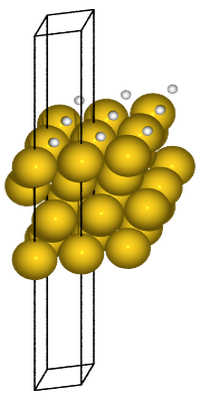

Adsorption energy for Au: 0.0797 eV

Running simulation for Pt
Time taken for slab energy calculation: 77.02 seconds
Time taken for gas energy calculation: 1.70 seconds
Time taken for adslab energy calculation: 94.73 seconds


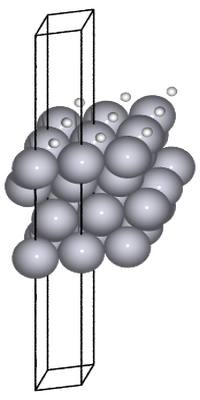

Adsorption energy for Pt: -0.5450 eV

Running simulation for Cu
Time taken for slab energy calculation: 46.48 seconds
Time taken for gas energy calculation: 1.80 seconds
Time taken for adslab energy calculation: 50.13 seconds


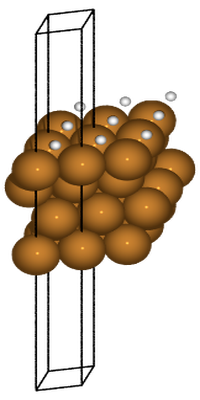

Adsorption energy for Cu: -0.3038 eV



In [25]:
from ase import Atoms
from ase.visualize import view
from gpaw import GPAW, PW
from ase.build import bulk, fcc111, add_adsorbate
from ase.constraints import FixAtoms
import time
import numpy as np

# Define parameters
elements = ['Au', 'Pt', 'Cu']
size = 1  # Example size, change as needed
N_layer = 4  # Number of layers for the slab
vac = 10.0  # Vacuum layer thickness
k = 4  # k-point setting for GPAW, adjust as needed
cutoff_energy = 400  # Energy cutoff for the plane waves

E_H_list=[]

for element in elements:
    print(f"Running simulation for {element}")

    surf = fcc111(element, (size, size, N_layer), vacuum=vac) # lattice constant will be taken from default tabulated values from ase
    median_z = np.median(surf.positions[:, 2])
    constraint = FixAtoms(mask=[atom.position[2] < (median_z + 0.01) for atom in surf])
    surf.set_constraint(constraint)
    # Set up the GPAW calculator
    calc = GPAW(mode=PW(cutoff_energy),  # increased cutoff energy
                kpts=(k, k, 1),
                xc='PBE',
                txt=f'{element}_slab.txt')
    surf.calc = calc

    start_time = time.time()
    E_slab = surf.get_potential_energy()
    elapsed_time = time.time() - start_time
    print(f"Time taken for slab energy calculation: {elapsed_time:.2f} seconds")
    # Set up the gas phase molecule (H2)
    gas = Atoms('H2',
                positions=[(0, 0, 0), (0, 0, 1.1)],
                cell=(a0, a0, a0),
                pbc=True)

    gas.calc = calc
    start_time = time.time()
    E_gas = gas.get_potential_energy()
    elapsed_time = time.time() - start_time
    print(f"Time taken for gas energy calculation: {elapsed_time:.2f} seconds")

    # Set up the adsorbate on the slab
    adsorbate_atom = Atoms('H')
    adslab = surf.copy()
    add_adsorbate(adslab, adsorbate_atom, 1.2, 'fcc')
    adslab.calc = calc
    start_time = time.time()
    E_adslab = adslab.get_potential_energy()
    elapsed_time = time.time() - start_time
    print(f"Time taken for adslab energy calculation: {elapsed_time:.2f} seconds")
    enlarge_and_visual(adslab)
    E_ads = E_adslab - E_gas / 2 - E_slab
    print(f'Adsorption energy for {element}: {E_ads:.4f} eV\n')
    E_H_list.append(E_ads)

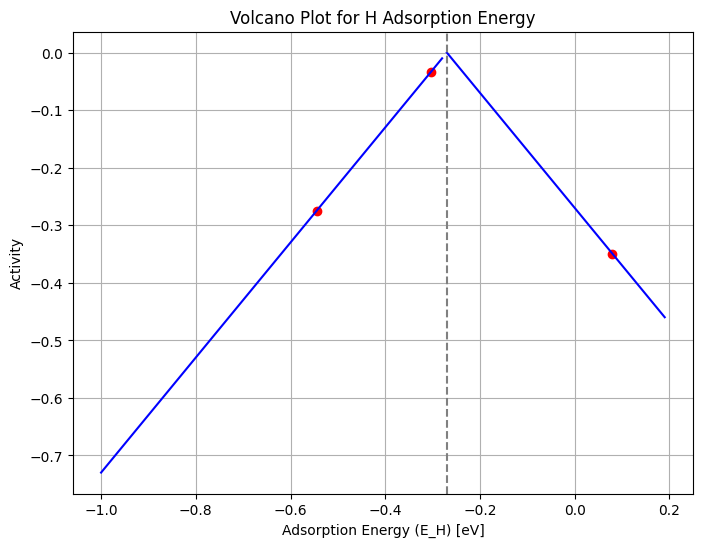

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Define the optimal value for the volcano plot
optimal_E_H = -0.27

# Generate x-values for the two lines
x_left = np.arange(-1, optimal_E_H, 0.01)
y_left = x_left - optimal_E_H

x_right = np.arange(optimal_E_H, 0.2, 0.01)
y_right = optimal_E_H - x_right

# Plot the volcano lines
plt.figure(figsize=(8, 6))
plt.plot(x_left, y_left, linestyle='-', color='blue')
plt.plot(x_right, y_right, linestyle='-', color='blue')

# Scatter the adsorption energies
elements = ['Au', 'Pt', 'Cu']
plt.scatter(E_H_list, [-abs( optimal_E_H - x) for x in E_H_list], color='red')


# Mark the optimal point
plt.axvline(x=optimal_E_H, color='gray', linestyle='--', label=f'Optimal E_H = {optimal_E_H} eV')

# Plot labels and title
plt.xlabel('Adsorption Energy (E_H) [eV]')
plt.ylabel('Activity')
plt.title('Volcano Plot for H Adsorption Energy')
plt.grid(True)

plt.show()
